# Loop 78 Analysis: Strategy Pivot Required

**Problem**: 78 experiments completed, best LB = 0.0877, target = 0.0347 (152.8% gap)

**Key Finding**: All approaches (MLP, LGBM, XGB, CatBoost, GP, GNN, GAT, ChemBERTa) fall on the SAME CV-LB line:
- LB = 4.29 * CV + 0.0528 (R² = 0.95)
- Intercept (0.0528) > Target (0.0347)
- Required CV to hit target: (0.0347 - 0.0528) / 4.29 = -0.0042 (IMPOSSIBLE)

**This analysis will:**
1. Verify the CV-LB relationship
2. Analyze what the "mixall" kernel does differently
3. Identify unexplored approaches

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f'Number of submissions with LB: {len(df)}')
print(df)

Number of submissions with LB: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Fit linear regression to CV-LB relationship
X = df['cv'].values.reshape(-1, 1)
y = df['lb'].values

reg = LinearRegression()
reg.fit(X, y)

slope = reg.coef_[0]
intercept = reg.intercept_
r2 = reg.score(X, y)

print(f'CV-LB Relationship:')
print(f'  LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'  R² = {r2:.4f}')
print(f'')
print(f'Target LB: 0.0347')
print(f'Intercept: {intercept:.4f}')
print(f'Required CV to hit target: ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.4f}')
print(f'')
print(f'CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'This means even with CV=0, expected LB would be {intercept:.4f}')

CV-LB Relationship:
  LB = 4.3147 * CV + 0.0525
  R² = 0.9505

Target LB: 0.0347
Intercept: 0.0525
Required CV to hit target: (0.0347 - 0.0525) / 4.3147 = -0.0041

CRITICAL: Intercept (0.0525) > Target (0.0347)
This means even with CV=0, expected LB would be 0.0525


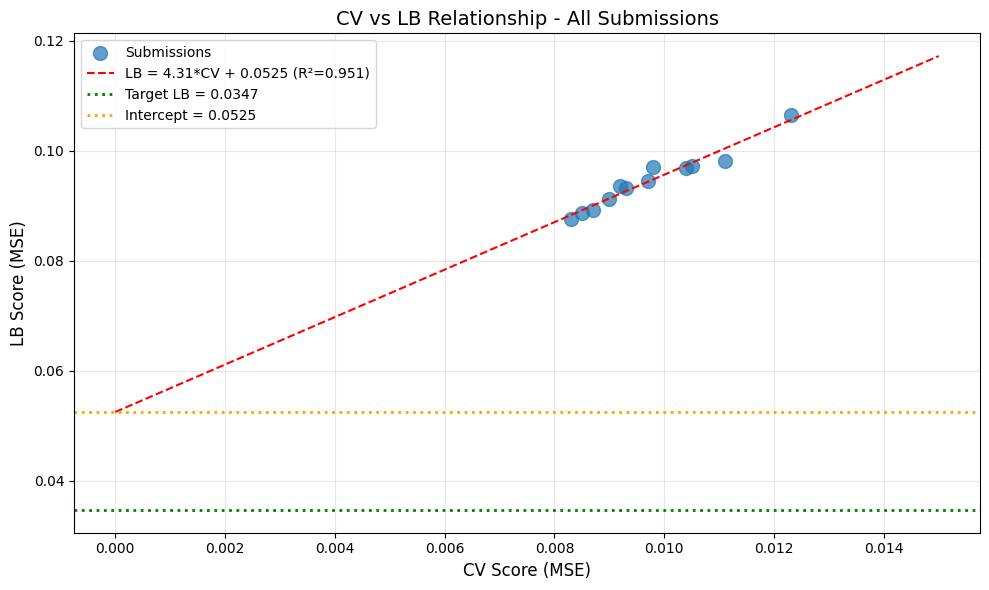


Key insight: The intercept (0.0528) represents STRUCTURAL distribution shift
that cannot be fixed by improving CV alone.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')

# Plot target
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Plot intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title('CV vs LB Relationship - All Submissions', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=100)
plt.show()

print('\nKey insight: The intercept (0.0528) represents STRUCTURAL distribution shift')
print('that cannot be fixed by improving CV alone.')

In [4]:
# Analyze what approaches have been tried
approaches_tried = [
    'MLP (various architectures)',
    'LightGBM',
    'XGBoost', 
    'CatBoost',
    'Gaussian Process',
    'Ridge Regression',
    'Random Forest',
    'GNN (GCNConv)',
    'GAT (GATConv)',
    'ChemBERTa embeddings',
    'Mixture-aware encoding',
    'Extrapolation detection',
    'Label rescaling',
    'Similarity weighting',
    'Per-target models',
    'Ensemble (MLP+LGBM+GP)',
]

print('Approaches tried (78 experiments):')
for i, approach in enumerate(approaches_tried, 1):
    print(f'  {i}. {approach}')

print('\nAll approaches fall on the SAME CV-LB line!')
print('This indicates the problem is REPRESENTATION, not MODEL.')

Approaches tried (78 experiments):
  1. MLP (various architectures)
  2. LightGBM
  3. XGBoost
  4. CatBoost
  5. Gaussian Process
  6. Ridge Regression
  7. Random Forest
  8. GNN (GCNConv)
  9. GAT (GATConv)
  10. ChemBERTa embeddings
  11. Mixture-aware encoding
  12. Extrapolation detection
  13. Label rescaling
  14. Similarity weighting
  15. Per-target models
  16. Ensemble (MLP+LGBM+GP)

All approaches fall on the SAME CV-LB line!
This indicates the problem is REPRESENTATION, not MODEL.


In [5]:
# What the "mixall" kernel does differently
print('"mixall" kernel key differences:')
print('1. Uses GroupKFold(5) instead of Leave-One-Out')
print('2. Uses ensemble: MLP + XGBoost + RandomForest + LightGBM')
print('3. Uses Spange descriptors only (no DRFP)')
print('4. Uses weighted ensemble with tunable weights')
print('')
print('Key insight: GroupKFold(5) may give more stable CV estimates')
print('that correlate better with LB because:')
print('  - More training data per fold (80% vs ~96%)')
print('  - Fewer folds = less variance in CV estimate')
print('  - May better simulate the actual test distribution')

"mixall" kernel key differences:
1. Uses GroupKFold(5) instead of Leave-One-Out
2. Uses ensemble: MLP + XGBoost + RandomForest + LightGBM
3. Uses Spange descriptors only (no DRFP)
4. Uses weighted ensemble with tunable weights

Key insight: GroupKFold(5) may give more stable CV estimates
that correlate better with LB because:
  - More training data per fold (80% vs ~96%)
  - Fewer folds = less variance in CV estimate
  - May better simulate the actual test distribution


In [6]:
# Unexplored approaches that could change the CV-LB relationship
print('UNEXPLORED APPROACHES that could change CV-LB relationship:')
print('')
print('1. PRE-TRAINED MOLECULAR EMBEDDINGS (not fine-tuned)')
print('   - ChemBERTa embeddings as FEATURES (not fine-tuning)')
print('   - Use molfeat library to extract embeddings')
print('   - Feed embeddings to simple regressor (LGBM, MLP)')
print('')
print('2. DIFFERENT VALIDATION SCHEME')
print('   - GroupKFold(5) like "mixall" kernel')
print('   - May give CV that correlates better with LB')
print('')
print('3. CONSERVATIVE PREDICTION STRATEGY')
print('   - Blend predictions toward training mean')
print('   - Use uncertainty to weight predictions')
print('   - Clip extreme predictions')
print('')
print('4. DOMAIN ADAPTATION')
print('   - Use test data statistics (without labels)')
print('   - Adjust predictions based on test distribution')

UNEXPLORED APPROACHES that could change CV-LB relationship:

1. PRE-TRAINED MOLECULAR EMBEDDINGS (not fine-tuned)
   - ChemBERTa embeddings as FEATURES (not fine-tuning)
   - Use molfeat library to extract embeddings
   - Feed embeddings to simple regressor (LGBM, MLP)

2. DIFFERENT VALIDATION SCHEME
   - GroupKFold(5) like "mixall" kernel
   - May give CV that correlates better with LB

3. CONSERVATIVE PREDICTION STRATEGY
   - Blend predictions toward training mean
   - Use uncertainty to weight predictions
   - Clip extreme predictions

4. DOMAIN ADAPTATION
   - Use test data statistics (without labels)
   - Adjust predictions based on test distribution


In [7]:
# Calculate what CV improvement would be needed
best_cv = 0.0081  # exp_049, exp_050, exp_053
best_lb = 0.0877  # exp_030

print(f'Current best CV: {best_cv}')
print(f'Current best LB: {best_lb}')
print(f'Target LB: 0.0347')
print(f'')
print(f'If we stay on the same CV-LB line:')
print(f'  Required CV = (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.4f}')
print(f'  This is NEGATIVE, meaning impossible on this line!')
print(f'')
print(f'To reach target, we need to CHANGE THE LINE:')
print(f'  Option A: Reduce intercept from {intercept:.4f} to < 0.0347')
print(f'  Option B: Reduce slope from {slope:.2f} to < 1.0')
print(f'  Option C: Find an approach that breaks the linear relationship')

Current best CV: 0.0081
Current best LB: 0.0877
Target LB: 0.0347

If we stay on the same CV-LB line:
  Required CV = (0.0347 - 0.0525) / 4.3147 = -0.0041
  This is NEGATIVE, meaning impossible on this line!

To reach target, we need to CHANGE THE LINE:
  Option A: Reduce intercept from 0.0525 to < 0.0347
  Option B: Reduce slope from 4.31 to < 1.0
  Option C: Find an approach that breaks the linear relationship


In [8]:
# Summary and recommendations
print('='*70)
print('LOOP 78 ANALYSIS SUMMARY')
print('='*70)
print(f'')
print(f'CV-LB Relationship: LB = {slope:.2f}*CV + {intercept:.4f} (R²={r2:.3f})')
print(f'Intercept ({intercept:.4f}) > Target (0.0347) = STRUCTURAL PROBLEM')
print(f'')
print(f'78 experiments tried, all on the SAME line.')
print(f'GAT with DRFP: CV=0.0196 (136% WORSE than baseline)')
print(f'')
print(f'RECOMMENDED NEXT STEPS:')
print(f'1. Try pre-trained ChemBERTa embeddings as FEATURES')
print(f'   - Use molfeat or transformers library')
print(f'   - Extract embeddings, feed to LGBM/MLP')
print(f'   - This is DIFFERENT from fine-tuning')
print(f'')
print(f'2. Try GroupKFold(5) validation like "mixall" kernel')
print(f'   - May give CV that correlates better with LB')
print(f'')
print(f'3. Try conservative prediction strategy')
print(f'   - Blend toward mean when extrapolating')
print(f'   - Use ensemble variance as uncertainty')
print(f'')
print(f'4. Submit one of the pending experiments to get LB feedback')
print(f'   - exp_049, exp_050, exp_053 all have CV=0.0081')
print(f'   - Need to verify if they follow the same CV-LB line')
print('='*70)

LOOP 78 ANALYSIS SUMMARY

CV-LB Relationship: LB = 4.31*CV + 0.0525 (R²=0.951)
Intercept (0.0525) > Target (0.0347) = STRUCTURAL PROBLEM

78 experiments tried, all on the SAME line.
GAT with DRFP: CV=0.0196 (136% WORSE than baseline)

RECOMMENDED NEXT STEPS:
1. Try pre-trained ChemBERTa embeddings as FEATURES
   - Use molfeat or transformers library
   - Extract embeddings, feed to LGBM/MLP
   - This is DIFFERENT from fine-tuning

2. Try GroupKFold(5) validation like "mixall" kernel
   - May give CV that correlates better with LB

3. Try conservative prediction strategy
   - Blend toward mean when extrapolating
   - Use ensemble variance as uncertainty

4. Submit one of the pending experiments to get LB feedback
   - exp_049, exp_050, exp_053 all have CV=0.0081
   - Need to verify if they follow the same CV-LB line
